In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

df = pd.read_parquet("data/bergingspercentage_rucphen_parquet/RUC0011_WTH_RIO.Bergingspercentage.parquet")
df_metadata = pd.read_parquet("data/bergingspercentage_rucphen_parquet/RUC0011_WTH_RIO.Bergingspercentage.metadata.parquet")


In [16]:
df.head()


,Date,Time,Value [m³/h]
0,01-01-2018,00:00:00,100.0
1,01-01-2018,00:05:00,100.0
2,01-01-2018,00:10:00,100.0
3,01-01-2018,00:15:00,100.0
4,01-01-2018,00:20:00,100.0


In [17]:
df_metadata.head(15)


,Key,Value
0,Station Site,Kenbelstraat
1,Station Name,Niveau Riool
2,Station Number,RUC0011_WTH_RIO
3,LocalX,99486
4,LocalY,396923
6,Parameter Name,Bergingspercentage
7,Parameter Type,WNS12107
8,Parameter Type Name,WATHTE [%] [PLAATSLR] [AW]
9,Time series Name,ContinueBerekening.F
10,Time series Unit,m³/h


In [18]:
# Data cleaning/preperation
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d-%m-%Y %H:%M:%S")
df.drop(columns= 'Date', inplace= True)

# Rename columns
df = df.rename(columns={'Value [m³/h]': 'percentage'})
# Define the desired order of columns
desired_order = ['timestamp', 'percentage']

# Reorder columns using reorder_levels
df = df[desired_order]
df.head()


,timestamp,percentage
0,2018-01-01 00:00:00,100.0
1,2018-01-01 00:05:00,100.0
2,2018-01-01 00:10:00,100.0
3,2018-01-01 00:15:00,100.0
4,2018-01-01 00:20:00,100.0


In [19]:
df["percentage"].max()


100.0

In [20]:
df["percentage"].min()


0.0

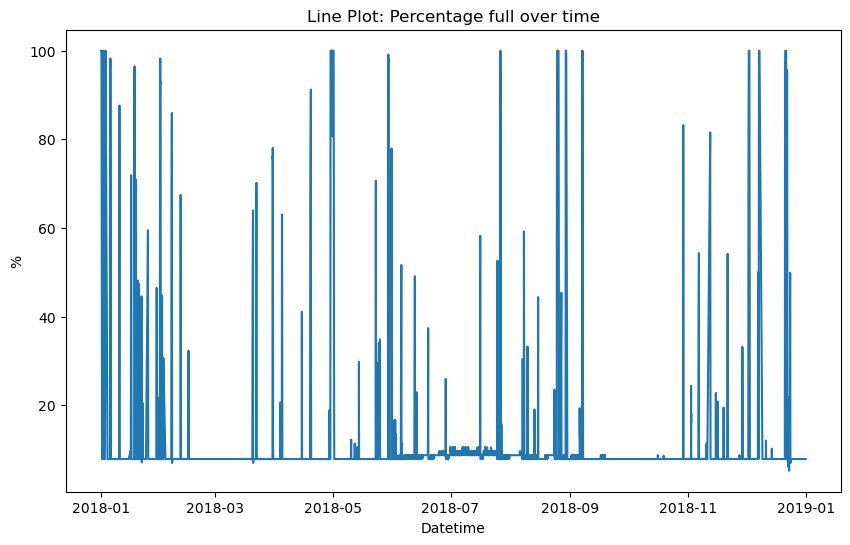

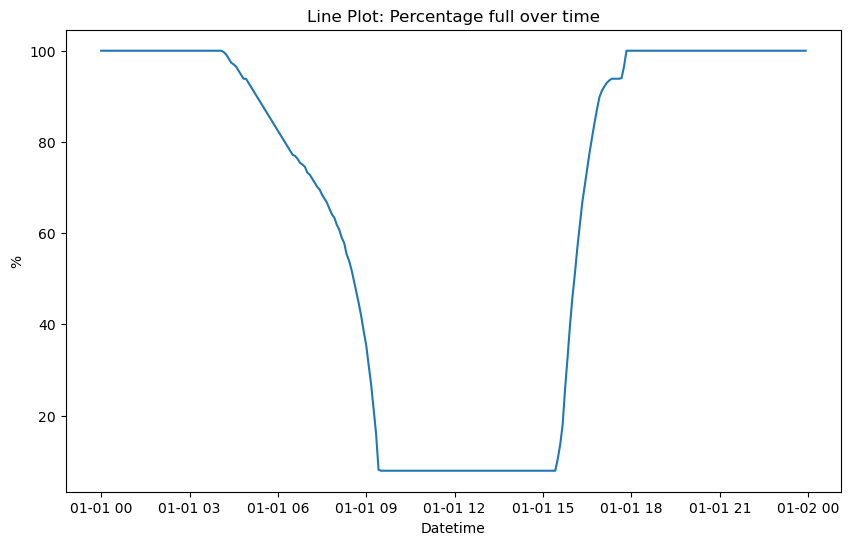

In [21]:
def create_plot(df, x,xlabel, y, ylabel, title):
    # Create a line plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x = x, y = y)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.show()

df_2018 = df[df['timestamp'].dt.year == 2018]
df_jan_2018 = df[(df['timestamp'].dt.year == 2018) & (df['timestamp'].dt.month == 1) & (df['timestamp'].dt.day == 1)]

create_plot(df_2018, 'timestamp','Datetime', 'percentage','%', 'Line Plot: Percentage full over time')
create_plot(df_jan_2018, 'timestamp','Datetime', 'percentage','%', 'Line Plot: Percentage full over time')


In [22]:
df_weather = pd.read_parquet("try_map/polygon_1663.parquet")
df_weather.sort_values(by=['timestamp'], inplace=True)
df_weather.head()


,timestamp,polygon_1663
159,2023-01-01 00:00:00,0.01001
158,2023-01-01 00:05:00,0.01000
157,2023-01-01 00:10:00,0.00000
156,2023-01-01 00:15:00,0.00000
155,2023-01-01 00:20:00,0.00000


In [23]:
merged_df = pd.merge(df_weather, df, on='timestamp', how='left')
# merged_df.to_parquet("data/rucphen_precipitation.parquet")
merged_df.head(10)


,timestamp,polygon_1663,percentage
0,2023-01-01 00:00:00,0.01001,11.404
1,2023-01-01 00:05:00,0.01000,11.302
2,2023-01-01 00:10:00,0.00000,11.010
3,2023-01-01 00:15:00,0.00000,10.718
4,2023-01-01 00:20:00,0.00000,10.326
5,2023-01-01 00:25:00,0.00000,9.741
6,2023-01-01 00:30:00,0.00000,9.156
7,2023-01-01 00:35:00,0.00000,8.671
8,2023-01-01 00:40:00,0.00000,8.379
9,2023-01-01 00:45:00,0.00000,8.086


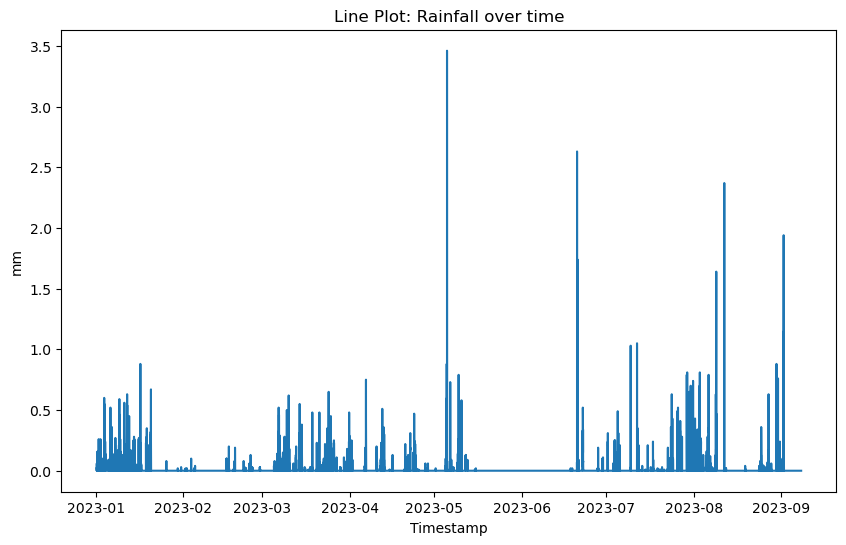

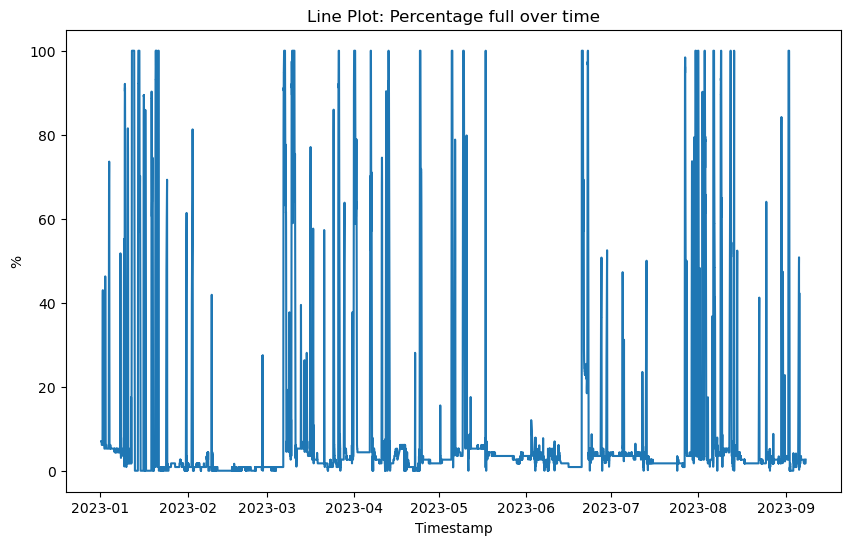

In [24]:
# Define the start and end timestamps
start_timestamp = pd.to_datetime('2023-01-01 08:00:00')
end_timestamp = pd.to_datetime('2023-12-31 08:00:00')

# Create a boolean mask for the specified time range
mask = (merged_df['timestamp'] >= start_timestamp) & (merged_df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
result_df = merged_df[mask]

#filter values that are less then 0 from polygon_1663
result_df = result_df[result_df['polygon_1663'] >= 0]


create_plot(result_df, 'timestamp','Timestamp', 'polygon_1663','mm', 'Line Plot: Rainfall over time')
create_plot(result_df, 'timestamp','Timestamp', 'percentage','%', 'Line Plot: Percentage full over time')


In [25]:
result_df['polygon_1663'].sum()


563.1718628406525

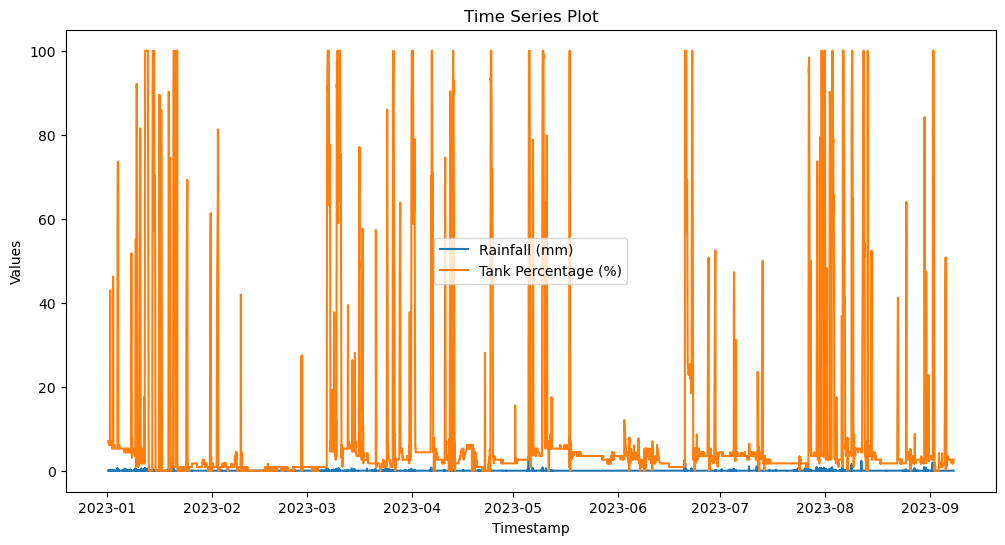

In [26]:
# 1. Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(result_df['timestamp'], result_df['polygon_1663'], label='Rainfall (mm)')
plt.plot(result_df['timestamp'], result_df['percentage'], label='Tank Percentage (%)')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Time Series Plot')
plt.legend()
plt.show()


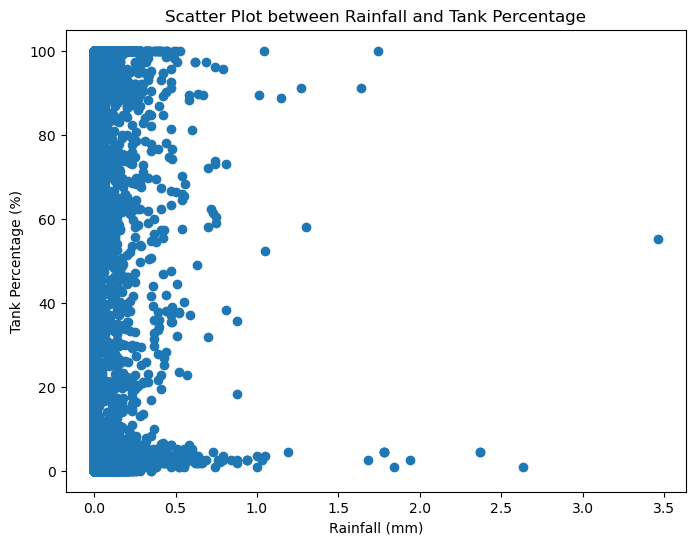

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(result_df['polygon_1663'], result_df['percentage'])
plt.xlabel('Rainfall (mm)')
plt.ylabel('Tank Percentage (%)')
plt.title('Scatter Plot between Rainfall and Tank Percentage')
plt.show()


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Ensure that 'result_df' is the DataFrame with the 'timestamp' column
result_df['timestamp'] = pd.to_datetime(result_df['timestamp'])

# Create time-based features
result_df['month'] = result_df['timestamp'].dt.month
result_df['day'] = result_df['timestamp'].dt.day
result_df['hour'] = result_df['timestamp'].dt.hour
result_df['minute'] = result_df['timestamp'].dt.minute
result_df['dayofweek'] = result_df['timestamp'].dt.dayofweek
result_df['dayofyear'] = result_df['timestamp'].dt.dayofyear
result_df['quarter'] = result_df['timestamp'].dt.quarter
result_df['is_weekend'] = result_df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Define the feature columns excluding 'year'
feature_columns = ['polygon_1663', 'month', 'day', 'hour', 'minute', 'dayofweek']
X = result_df[feature_columns]  # Features
y = result_df['percentage']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that creates polynomial features and then applies linear regression
degree = 2  # Degree of the polynomial features, can be adjusted based on the dataset
polynomial_regression = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model on the training data
polynomial_regression.fit(X_train, y_train)

# Predict on the testing data
y_pred = polynomial_regression.predict(X_test)

# Calculate metrics to evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the model performance metrics
(mse, r2)


(464.2111011358366, 0.06533742476336046)

In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define the models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(C=1.0, epsilon=0.2)
}

# Dictionary to store the results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate and store metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R-squared': r2}

results


{'Random Forest': {'MSE': 5.809117223524433, 'R-squared': 0.9883036738011958},
 'Gradient Boosting': {'MSE': 341.71273127572294,
  'R-squared': 0.3119809056185092},
 'Support Vector Regression': {'MSE': 546.9961059011778,
  'R-squared': -0.10134546057830152}}

In [35]:
model = RandomForestRegressor(n_estimators=300, random_state=42)

feature_columns = ['polygon_1663', 'month', 'day', 'hour', 'minute', 'dayofweek', 'is_weekend']
X = result_df[feature_columns]  # Features

# Dictionary to store the results
results = {}

# Train and evaluate each model

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate and store metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
results = {'MSE': mse, 'R-squared': r2}

results 


{'MSE': 5.767370145832512, 'R-squared': 0.988387729161028}

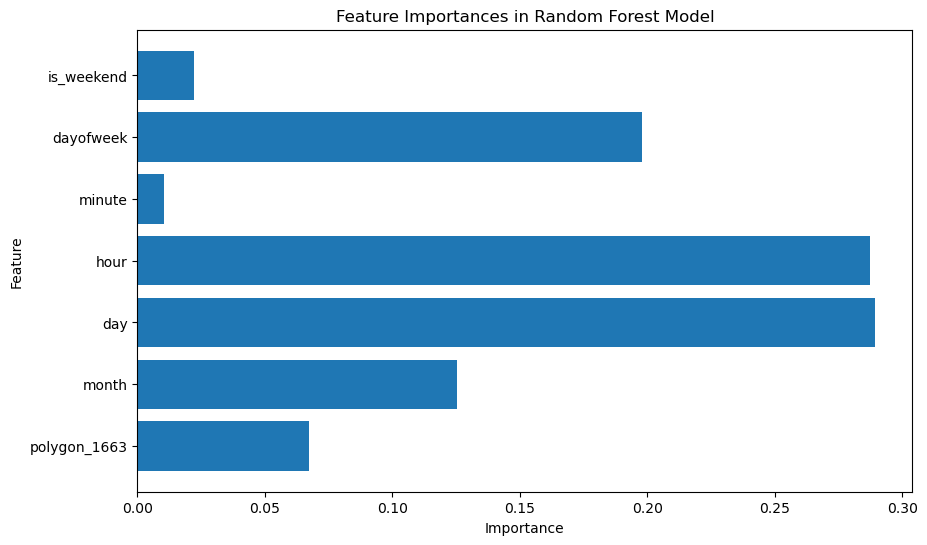

{'Training MSE': 0.7039084232323338,
 'Test MSE': 5.743479905752165,
 'Training R-squared': 0.9985562077684671,
 'Test R-squared': 0.9884358307968181}

In [42]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


feature_columns = ['polygon_1663', 'month', 'day', 'hour', 'minute', 'dayofweek', 'is_weekend'] 
X = result_df[feature_columns]  # Features

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Feature Importance
model.fit(X_train, y_train)  # Refitting the model on the entire training set


# Step 3: Checking for Overfitting by comparing training and test set performance
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

# Prepare the results
results = {
    'Training MSE': train_mse,
    'Test MSE': test_mse,
    'Training R-squared': train_r2,
    'Test R-squared': test_r2
}

# Ensure this matches the model's features

# Re-extract feature importances from the trained model
feature_importances = model.feature_importances_

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.show()

results
